In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import os

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedikram","key":"7183bfa63941895637e9b935b32539c8"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

Dataset URL: https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
License(s): unknown
100% 3.57G/3.58G [00:34<00:00, 162MB/s]
100% 3.58G/3.58G [00:34<00:00, 110MB/s]


In [5]:
import zipfile

dataset_path = "/content/fruits-fresh-and-rotten-for-classification.zip"
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

# Check extracted files
import os
os.listdir("/content/dataset/dataset")

['test', 'dataset', 'train']

In [6]:
train_dir = "/content/dataset/dataset/train"
test_dir = "/content/dataset/dataset/test"

In [7]:
# Image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training and Testing Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [10]:
# Load Pretrained MobileNetV2 Model (without the top layer)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(6, activation='softmax')(x)  # FIXED: Ensure it's connected to `x`

# Compile Model
model = Model(inputs=base_model.input, outputs=output_layer)  # Now output_layer is a valid Keras tensor
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train Model
EPOCHS = 20
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 189s 520ms/step - accuracy: 0.6253 - loss: 1.0260 - val_accuracy: 0.9396 - val_loss: 0.1956
Epoch 2/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 167s 490ms/step - accuracy: 0.9245 - loss: 0.2310 - val_accuracy: 0.9611 - val_loss: 0.1242
Epoch 3/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 166s 487ms/step - accuracy: 0.9503 - loss: 0.1563 - val_accuracy: 0.9674 - val_loss: 0.1010
Epoch 4/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 163s 479ms/step - accuracy: 0.9584 - loss: 0.1225 - val_accuracy: 0.9718 - val_loss: 0.0852
Epoch 5/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 168s 493ms/step - accuracy: 0.9672 - loss: 0.1023 - val_accuracy: 0.9748 - val_loss: 0.0735
Epoch 6/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 174s 509ms/step - accuracy: 0.9713 - loss: 0.0913 - val_accuracy: 0.9781 - val_loss: 0.0670
Epoch 7/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 165s 483ms/step - accuracy: 0.9746 - loss: 0.0758 - val_accuracy: 0.9800 - val_loss: 0.0601
Epoch 8/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 165s 484ms/step - accuracy: 0.9737 -

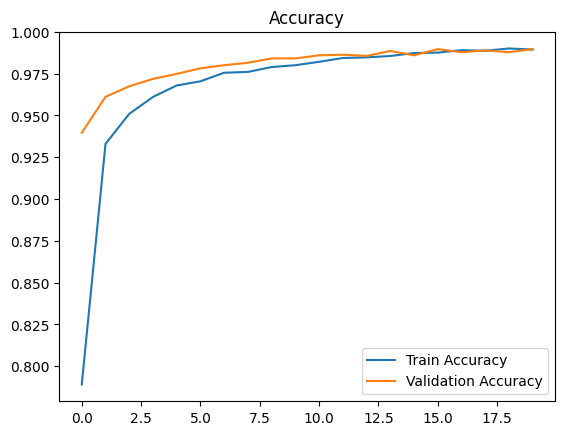

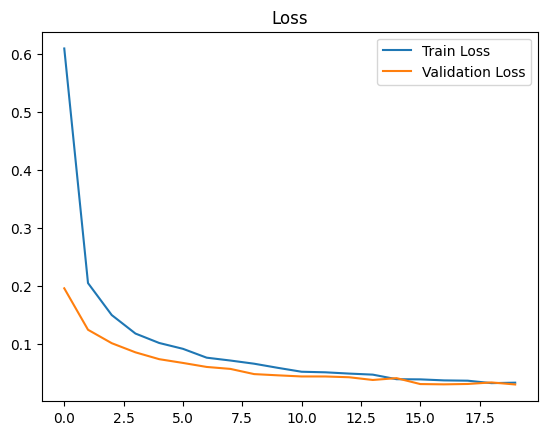

In [12]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

print(' ')

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [13]:
# Evaluate on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.9907 - loss: 0.0249
Test Accuracy: 98.96%
Test Loss: 0.0299


85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step


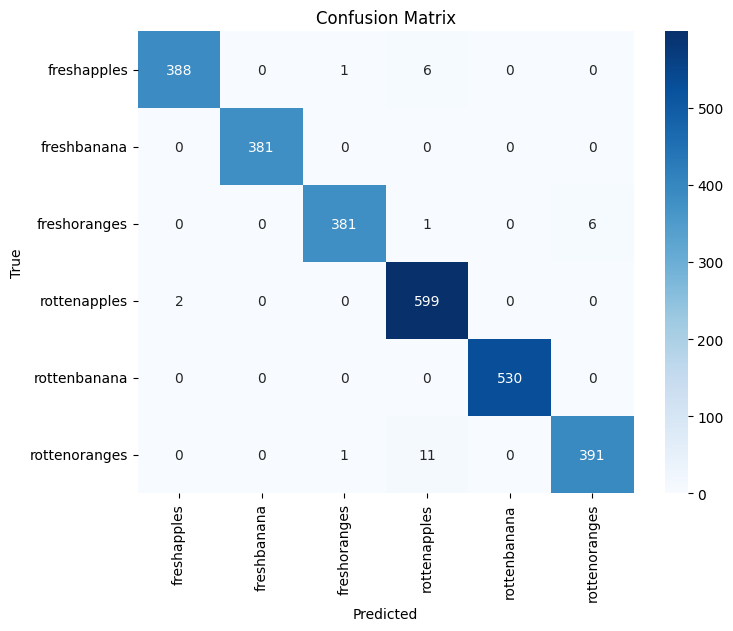

Classification Report:
                precision    recall  f1-score   support

  freshapples       0.99      0.98      0.99       395
  freshbanana       1.00      1.00      1.00       381
 freshoranges       0.99      0.98      0.99       388
 rottenapples       0.97      1.00      0.98       601
 rottenbanana       1.00      1.00      1.00       530
rottenoranges       0.98      0.97      0.98       403

     accuracy                           0.99      2698
    macro avg       0.99      0.99      0.99      2698
 weighted avg       0.99      0.99      0.99      2698



In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

In [15]:
model.save('fruit_classification_model.h5')

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

In [26]:
def predict_image(image_path, model_path='/content/fruit_classification_model.h5'):
    # Load the trained model
    model = load_model(model_path)

    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    predictions = model.predict(img_array)
    class_indices = train_generator.class_indices
    class_labels = {v: k for k, v in class_indices.items()}

    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions) * 100

    return f'Predicted Class: {class_labels[predicted_class]}, Confidence: {confidence:.2f}%'

In [28]:
predict_image('/content/rottenorange1.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


'Predicted Class: rottenoranges, Confidence: 100.00%'